## Work time distribution

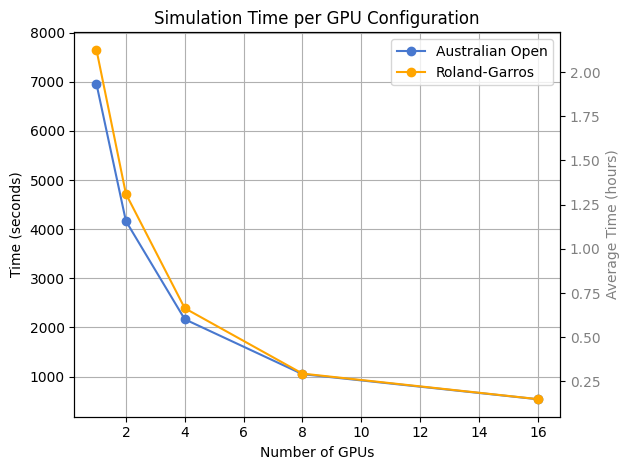

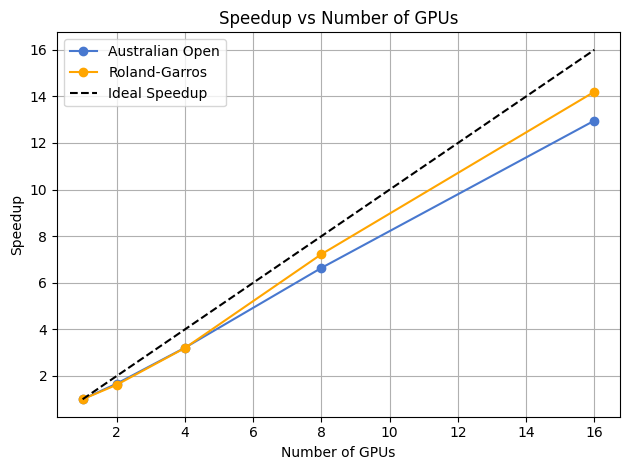

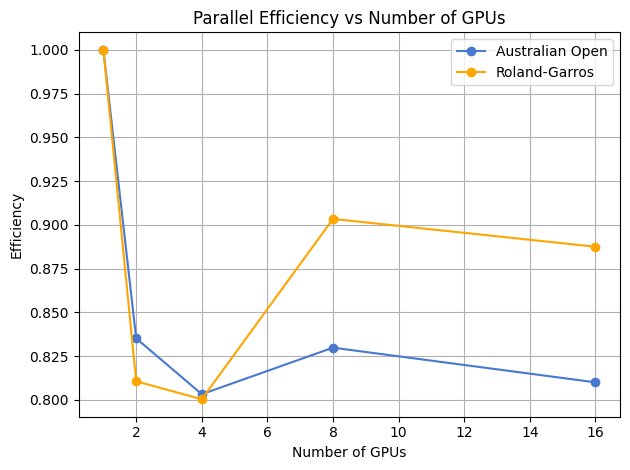

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

base_rg_dir = Path("./RG_2025/")
base_ao_dir = Path("./AUS_OPEN_2025/")

ao_paths = {
    1: base_ao_dir / "mc_ao_results_1gpu" / "times.csv",
    2: base_ao_dir / "mc_ao_results_2gpu" / "times.csv",
    4: base_ao_dir / "mc_ao_results_4gpu" / "times.csv",
    8: base_ao_dir / "mc_ao_results_8gpu" / "times.csv",
    16: base_ao_dir / "mc_ao_results_16gpu" / "times.csv",
}

rg_paths = {
    1: base_rg_dir / "mc_rg_results_1gpu" / "times.csv",
    2: base_rg_dir / "mc_rg_results_2gpu" / "times.csv",
    4: base_rg_dir / "mc_rg_results_4gpu" / "times.csv",
    8: base_rg_dir / "mc_rg_results_8gpu" / "times.csv",
    16: base_rg_dir / "mc_rg_results_16gpu" / "times.csv",
}

def load_average_times(paths):
    records = []
    for gpu, path in paths.items():
        try:
            df = pd.read_csv(path, header=None, names=["job_index", "runs", "duration"])
            avg_time = df["duration"].mean()
            records.append((gpu, avg_time))
        except Exception as e:
            print(f"Erreur de chargement {path} : {e}")
    df = pd.DataFrame(records, columns=["GPU", "AvgTime"])
    df = df.sort_values("GPU")
    df["Speedup"] = df["AvgTime"].iloc[0] / df["AvgTime"]
    df["Efficiency"] = df["Speedup"] / df["GPU"]
    return df

df_ao = load_average_times(ao_paths)
df_rg = load_average_times(rg_paths)

plt.style.use("seaborn-v0_8-muted")


fig, ax1 = plt.subplots()
ax1.plot(df_ao["GPU"], df_ao["AvgTime"], marker='o', label="Australian Open")
ax1.plot(df_rg["GPU"], df_rg["AvgTime"], marker='o', color='orange', label="Roland-Garros")
ax1.set_xlabel("Number of GPUs")
ax1.set_ylabel("Time (seconds)", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_title("Simulation Time per GPU Configuration")
ax2 = ax1.twinx()
ax2.set_ylabel("Average Time (hours)", color='gray')
ax2.set_ylim([t / 3600 for t in ax1.get_ylim()])
ax2.tick_params(axis='y', labelcolor='gray')
ax1.legend(loc='upper right')
ax1.grid(True)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.plot(df_ao["GPU"], df_ao["Speedup"], marker='o', label="Australian Open")
ax.plot(df_rg["GPU"], df_rg["Speedup"], marker='o', color='orange', label="Roland-Garros")
ax.plot(df_ao["GPU"], df_ao["GPU"], 'k--', label="Ideal Speedup")
ax.set_title("Speedup vs Number of GPUs")
ax.set_xlabel("Number of GPUs")
ax.set_ylabel("Speedup")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.plot(df_ao["GPU"], df_ao["Efficiency"], marker='o', label="Australian Open")
ax.plot(df_rg["GPU"], df_rg["Efficiency"], marker='o', color='orange', label="Roland-Garros")
ax.set_title("Parallel Efficiency vs Number of GPUs")
ax.set_xlabel("Number of GPUs")
ax.set_ylabel("Efficiency")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


## Montecarlo top winrates

In [19]:
import json
import pandas as pd
from pathlib import Path

# === 1. Define the result directories for both tournaments ===
ao_result_dirs = sorted([d for d in Path("AUS_OPEN_2025").iterdir() if d.is_dir() and d.name.startswith("mc_ao_results_4gpu")])
rg_result_dirs = sorted([d for d in Path("RG_2025").iterdir() if d.is_dir() and d.name.startswith("mc_rg_results_4gpu")])

# === 2. Load all partial result files into a single DataFrame ===
def load_partial_results(result_dirs):
    records = []
    for d in result_dirs:
        for fn in sorted(d.glob("partial_*.json")):
            data = json.loads(fn.read_text(encoding="utf-8"))
            runs = data.get("runs", 0)
            for stat in data.get("stats", []):
                records.append({
                    "id": stat.get("id"),
                    "name": stat.get("name"),
                    "wins": stat.get("wins", 0),
                    "quarterfinals": stat.get("quarterfinals", 0),
                    "semifinals": stat.get("semifinals", 0),
                    "runs": runs
                })
    return pd.DataFrame(records)

# === 3. Aggregate player statistics across all partial runs ===
def aggregate_results(df):
    agg = (
        df.groupby(["id", "name"], as_index=False)
          .agg({
              "wins": "sum",
              "quarterfinals": "sum",
              "semifinals": "sum",
              "runs": "sum"
          })
    )
    # Compute tournament probabilities
    agg["champion_probability"] = agg["wins"] / agg["runs"]
    agg["qf_rate"] = agg["quarterfinals"] / agg["runs"]
    agg["sf_rate"] = agg["semifinals"] / agg["runs"]
    return agg.sort_values("champion_probability", ascending=False)

# === 4. Load and process data for both tournaments ===
df_ao = load_partial_results(ao_result_dirs)
df_rg = load_partial_results(rg_result_dirs)

# Extract final summary tables
agg_ao = aggregate_results(df_ao)[[
    "name", "wins", "runs", "champion_probability",
    "semifinals", "sf_rate", "quarterfinals", "qf_rate"
]]

agg_rg = aggregate_results(df_rg)[[
    "name", "wins", "runs", "champion_probability",
    "semifinals", "sf_rate", "quarterfinals", "qf_rate"
]]

# === 5. Display the results nicely ===
pd.set_option("display.float_format", "{:.2%}".format)

In [20]:
print("\n--- Australian Open 2025 ---")
agg_ao.head(10)


--- Australian Open 2025 ---


,name,wins,runs,champion_probability,semifinals,sf_rate,quarterfinals,qf_rate
72,Sinner J.,844,5000,16.88%,1480,29.60%,2218,44.36%
81,Alcaraz C.,535,5000,10.70%,920,18.40%,1438,28.76%
35,Rublev A.,284,5000,5.68%,1067,21.34%,1718,34.36%
62,De Minaur A.,276,5000,5.52%,973,19.46%,1591,31.82%
67,Korda S.,217,5000,4.34%,527,10.54%,1037,20.74%
20,Medvedev D.,216,5000,4.32%,782,15.64%,1184,23.68%
95,Shelton B.,159,5000,3.18%,499,9.98%,834,16.68%
3,Djokovic N.,151,5000,3.02%,397,7.94%,637,12.74%
96,Mensik J.,134,5000,2.68%,512,10.24%,849,16.98%
0,Zverev A.,127,5000,2.54%,488,9.76%,758,15.16%


In [21]:
print("\n--- Roland Garros 2025 ---")
agg_rg.head(10)


--- Roland Garros 2025 ---


,name,wins,runs,champion_probability,semifinals,sf_rate,quarterfinals,qf_rate
87,ALCARAZ Carlos,484,5000,9.68%,1009,20.18%,1411,28.22%
45,TSITSIPAS Stefanos,453,5000,9.06%,987,19.74%,1342,26.84%
74,SINNER Jannik,413,5000,8.26%,1060,21.20%,1476,29.52%
3,DJOKOVIC Novak,326,5000,6.52%,880,17.60%,1478,29.56%
0,ZVEREV Alexander,286,5000,5.72%,813,16.26%,1254,25.08%
52,RUUD Casper,197,5000,3.94%,555,11.10%,1054,21.08%
90,RUNE Holger,197,5000,3.94%,680,13.60%,1088,21.76%
37,RUBLEV Andrey,168,5000,3.36%,550,11.00%,854,17.08%
80,MUSETTI Lorenzo,113,5000,2.26%,470,9.40%,783,15.66%
40,FRITZ Taylor,107,5000,2.14%,479,9.58%,854,17.08%
